In [1]:
import cv2
import numpy as np
from skimage import io, img_as_float, img_as_ubyte
from matplotlib import pyplot as plt
from functions import apply_vegetative_index
import glob
import re
from skimage.filters import try_all_threshold, threshold_mean
import skimage.filters as skfil
from functions import reorder_file_paths, extract_filename_number
from skimage.restoration import denoise_nl_means, estimate_sigma
from scipy import ndimage

In [9]:
# Import image
img = cv2.imread('test_photos/image_14.jpg')

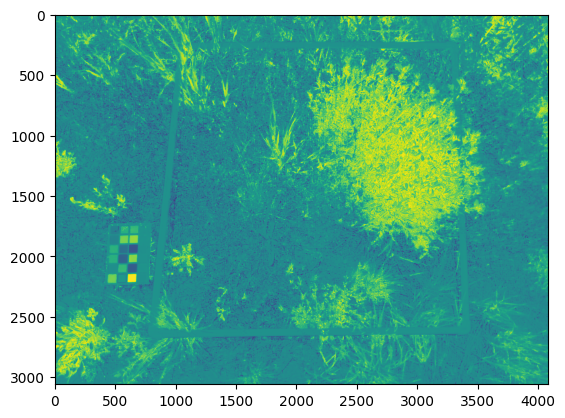

In [11]:
vegetated_img = apply_vegetative_index(img, index_type='rgbvi')

plt.imshow(vegetated_img)

Now try it on all of the test images

In [ ]:
# Define a path to the folder that contains the photos I want to test with loops
path = 'test_photos/*'

# Function to extract numeric part of the filename for sorting
def numerical_sort(value):
    # Use regexp to extract the digits in the names
    numbers = re.findall(r'\d+', value)
    return int(numbers[0]) if numbers else 0

# Get a sorted list of files in the folder because otherwise, glob will read the files in the order determined by the operating system.
files = sorted(glob.glob(path), key = numerical_sort)

# Verify that the filenames are in order
print(files)

In [22]:
# Loop through every file in the folder specified by the path
for i, file in enumerate(files):
    # Read in the color image
    img = cv2.imread(file)

    # Use the excess green vegetative index on every image
    vegetated_img = apply_vegetative_index(img, index_type='exg-exr')

    plt.imsave(f'results/vi_rgbvi_gray/image_{i}.jpg', vegetated_img, cmap='gray')

#     # Show each image in its own window.
#     cv2.imshow(f'image {i}', vegetated_img)

# # Allows you to close all windows (individually, or close all with ctrl+w)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

c:\Users\dusty\Documents\REU_2024\mtech_reu_plants\functions.py:57: RuntimeWarning: divide by zero encountered in divide
  exr = (1.4 * r - g) / g + r + b + 1e-6
c:\Users\dusty\Documents\REU_2024\mtech_reu_plants\functions.py:57: RuntimeWarning: invalid value encountered in divide
  exr = (1.4 * r - g) / g + r + b + 1e-6
c:\Users\dusty\Documents\REU_2024\mtech_reu_plants\functions.py:69: RuntimeWarning: invalid value encountered in cast
  vegetated_img = normalized.astype(np.uint8)


Joel would like to see these VI segmentations side by side.  
I'll do it for the methods at which I've gotten reasonable results - ExG, GRVI, and RGBVI.

In [ ]:
index_types = ['exg', 'grvi', 'rgbvi']

In [ ]:
# Try it on one image first
fig, axes = plt.subplots(nrows=1, ncols=2)

og_img = cv2.imread('test_photos/image_13.jpg')
modified_image = cv2.imread('results/vi_rgbvi/image_13.jpg')

# Convert images from BGR to RGB (since OpenCV loads images in BGR format)
og_img = cv2.cvtColor(og_img, cv2.COLOR_BGR2RGB)
modified_image = cv2.cvtColor(modified_image, cv2.COLOR_BGR2RGB)

axes[0].imshow(og_img)
axes[0].axis('off')  # Hide the axis

axes[1].imshow(modified_image)
axes[1].axis('off')  # Hide the axis

plt.savefig('results/vi_side_by_sides/sbs_image_2.jpg')


In [ ]:
for index_type in index_types:
    for i, file in enumerate(files):
        fig, axes = plt.subplots(nrows=1, ncols=2)

        og_img = cv2.imread(file)
        modified_image = cv2.imread(f'results/vi_{index_type}/image_{i}.jpg')

        # Convert images from BGR to RGB (since OpenCV loads images in BGR format)
        og_img = cv2.cvtColor(og_img, cv2.COLOR_BGR2RGB)
        modified_image = cv2.cvtColor(modified_image, cv2.COLOR_BGR2RGB)

        axes[0].imshow(og_img)
        axes[0].axis('off')  # Hide the axis

        axes[1].imshow(modified_image)
        axes[1].axis('off')  # Hide the axis

        plt.savefig(f'results/vi_side_by_sides/sbs_{index_type}_image_{i}.jpg')


Segment / threshold images based on results of RGBVI calculations

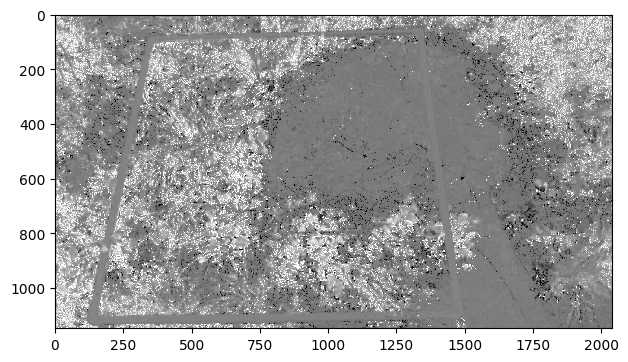

In [31]:
# Start rgbvi process fresh because I probably shouldn't use the color image that was saved because the grayscale images manifest in viridis
img = cv2.imread('test_photos/image_1.jpg')

img_rgbvi = apply_vegetative_index(img, index_type='rgbvi')

io.imshow(img_rgbvi)

# Convert the image to a float
img_float = img_as_float(img_rgbvi)

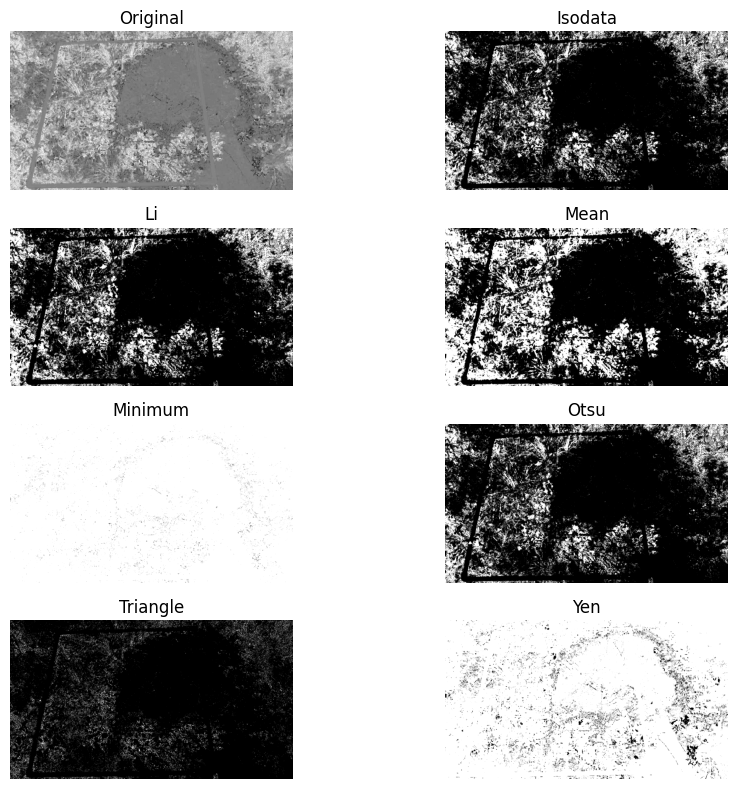

In [22]:
# Show different thresholding methods
fig, ax = try_all_threshold(img_float, figsize=(10,8), verbose=False)

Mean looks pretty good to me.

In [40]:
# Apply the mean threshold.
thresh_otsu = skfil.threshold_otsu(img_float)
thresh_mean = skfil.threshold_mean(img_float)


print(thresh_otsu, thresh_mean) # Threshold is the value that will be the cutoff for what is black and what is white.

# If image is <= to the threshold number, it's True. False otherwise.
binary_otsu = img_float <= thresh_otsu
binary_mean = img_float <= thresh_mean

cv2.imshow('binary otsu', img_as_ubyte(binary_otsu))
cv2.imshow('binary mean', img_as_ubyte(binary_mean))

cv2.waitKey(0)
cv2.destroyAllWindows()

0.669921875 0.5547556839569875


Now do it on all the images. 

In [9]:
files = reorder_file_paths('test_photos/*')

print(files)

['test_photos\\image_0.jpg', 'test_photos\\image_1.jpg', 'test_photos\\image_2.jpg', 'test_photos\\image_3.jpg', 'test_photos\\image_4.jpg', 'test_photos\\image_5.jpg', 'test_photos\\image_6.JPG', 'test_photos\\image_7.JPG', 'test_photos\\image_8.JPG', 'test_photos\\image_9.JPG', 'test_photos\\image_10.JPG', 'test_photos\\image_11.jpg', 'test_photos\\image_12.jpg', 'test_photos\\image_13.jpg', 'test_photos\\image_14.jpg', 'test_photos\\image_15.jpg', 'test_photos\\image_16.jpg', 'test_photos\\test_image_17.jpg', 'test_photos\\test_image_18.JPG', 'test_photos\\test_image_19.JPG', 'test_photos\\test_image_20.jpg', 'test_photos\\test_image_21.jpg', 'test_photos\\test_image_22.jpg', 'test_photos\\test_image_23.jpg', 'test_photos\\test_image_24.jpg']


In [18]:
# Loop through every file in the folder specified by the path
for i, file in enumerate(files):
    # Read in the color image
    img = cv2.imread(file)

    # Reduce the image size by half because the windows are too huge.
    img = cv2.resize(img, (0, 0), fx=.5, fy=.5)

    # Use the excess green vegetative index on every image
    rgbvi_img = apply_vegetative_index(img, index_type='rgbvi')

    # Convert image to a float
    img_float = img_as_float(rgbvi_img)

    # Apply Otsu threshold to image
    thresh_otsu = skfil.threshold_otsu(img_float)

    # Pixel is true if it's over the threshold, and false otherwise
    binary_otsu = img_float <= thresh_otsu
    
    plt.imsave(f'results/post_rgbvi_thresholding/image_{i}.jpg', binary_otsu)
#     cv2.imshow(f'otsu_test_{i}', img_as_ubyte(binary_otsu))

# cv2.waitKey(0)
# cv2.destroyAllWindows()
    

Boxplot that displays every VI value in an image

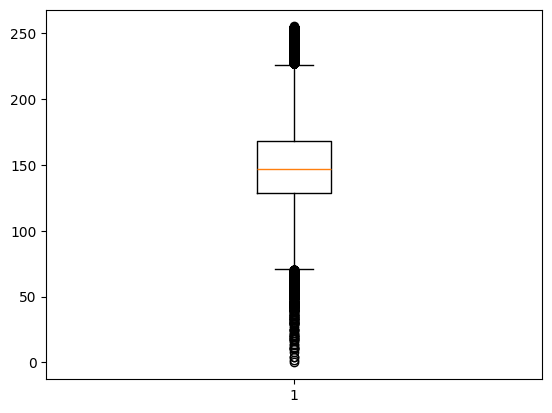

In [21]:
cv2.imread('test_photos/image_1')

rgbvi_img = apply_vegetative_index(img, index_type='rgbvi')

vi_values = rgbvi_img.flatten()

plt.boxplot(vi_values)

plt.show()

Good heavens, it's hideous! I'm relocating this part of the project to an R script after I finish bleaching my eyes. 

## Making greenhouse images for the boxplots comparing greenness
where everything that's not leaf is blackened or transparent 

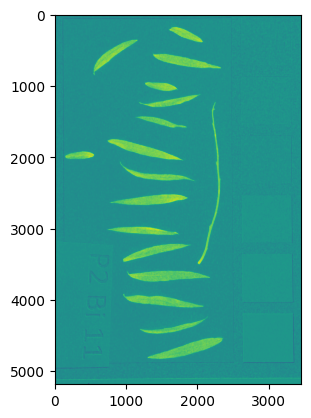

In [2]:
path = 'test_photos_greenhouse/image_10.jpg'

# Load in the image in color
img = cv2.imread(path, 1)

# Apply vegetative index
img_exg = apply_vegetative_index(img, 'exg')

plt.imshow(img_exg)

# cv2.imshow('img', img_rgbvi)

# cv2.waitKey(0)
# cv2.destroyAllWindows()

Note here that the ExG vegetative index seems to work better on the greenhouse images. I will be using that index for the boxplots. 

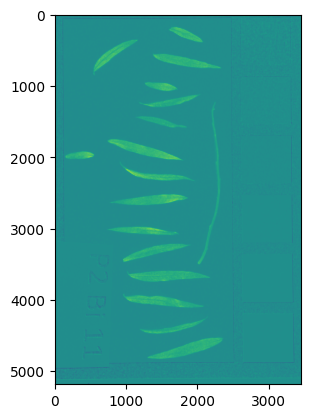

In [9]:
img_rgbvi = apply_vegetative_index(img, 'rgbvi')
plt.imshow(img_rgbvi)


(array([2.000000e+00, 2.000000e+00, 1.000000e+00, 3.000000e+00,
        2.000000e+00, 1.000000e+00, 3.000000e+00, 5.000000e+00,
        7.000000e+00, 1.100000e+01, 8.000000e+00, 2.700000e+01,
        3.800000e+01, 5.000000e+01, 1.530000e+02, 1.110000e+02,
        1.880000e+02, 9.000000e+01, 4.160000e+02, 3.460000e+02,
        6.410000e+02, 1.600000e+02, 7.510000e+02, 4.910000e+02,
        9.400000e+02, 8.280000e+02, 8.800000e+02, 1.475000e+03,
        1.351000e+03, 2.503000e+03, 8.830000e+02, 3.591000e+03,
        2.593000e+03, 6.136000e+03, 2.254000e+03, 7.501000e+03,
        5.261000e+03, 1.156000e+04, 8.172000e+03, 1.002900e+04,
        1.680200e+04, 1.895500e+04, 4.174400e+04, 3.589800e+04,
        1.030010e+05, 1.504920e+05, 4.592660e+05, 4.448090e+05,
        1.898989e+06, 2.564881e+06, 4.041668e+06, 4.082921e+06,
        3.579910e+05, 1.564013e+06, 3.166530e+05, 2.752940e+05,
        2.996600e+04, 7.024200e+04, 2.591000e+04, 2.904300e+04,
        1.629700e+04, 1.365000e+04, 1.76

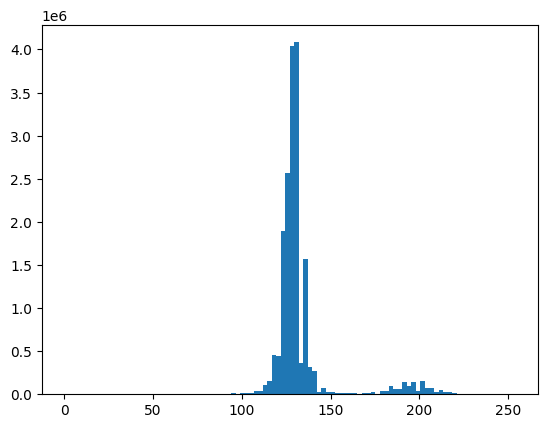

In [12]:
# Investigate histogram of exg modified image
plt.hist(img_exg.flatten(), bins = 100)

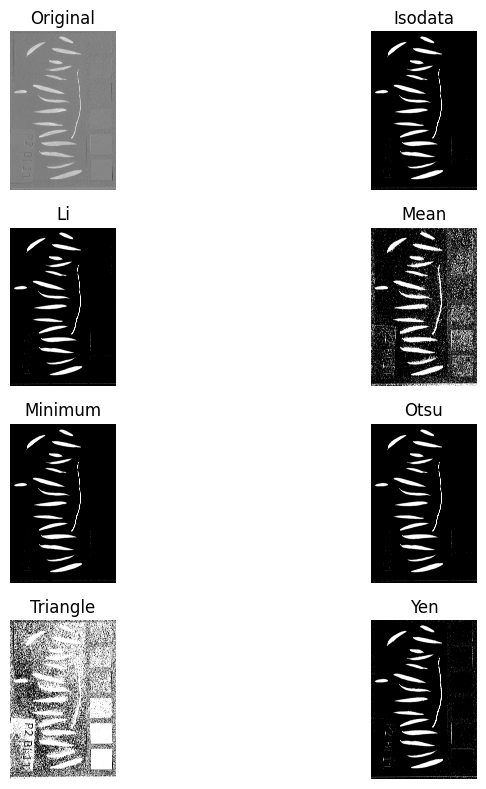

In [3]:
# Segment the image based on the two segmented peaks so beautifully visible here
# Convert the image into a float
img_float = img_as_float(img_exg)

# Show different thresholding methods
fig, ax = try_all_threshold(img_float, figsize=(10,8), verbose=False)

In [10]:
# Apply a threshold method
thresh_min = skfil.threshold_minimum(img_float)
thresh_isodata = skfil.threshold_isodata(img_float)
thresh_li = skfil.threshold_li(img_float)
thresh_otsu = skfil.threshold_otsu(img_float)

binary_isodata = img_as_ubyte(img_float <= thresh_isodata)
binary_li = img_as_ubyte(img_float <= thresh_li)
binary_otsu = img_as_ubyte(img_float <= thresh_otsu)



# If image is <= to the threshold number, it's True. False otherwise.
binary_min = img_float <= thresh_min

# Convert back into a ubyte
img_ubyte = img_as_ubyte(binary_min)

# plt.imshow(img_ubyte)

plt.imsave('results/greenhouse_min.jpg', img_ubyte, cmap='gray')
plt.imsave('results/greenhouse_isodata.jpg', binary_isodata, cmap='gray')
plt.imsave('results/greenhouse_li.jpg', binary_li, cmap='gray')
plt.imsave('results/greenhouse_otsu.jpg', binary_otsu, cmap='gray')


Now use a for loop to do the same process on every greenhouse test image. 

In [17]:
path = 'test_photos_greenhouse/*'

# Reorder the filepaths to keep the index consistent
files = reorder_file_paths(path)

for i, file in enumerate(files):
    # Read in the files in color
    img = cv2.imread(file, 1)
        
    # Apply vegetative index
    img_exg = apply_vegetative_index(img, 'exg')

    # Convert the image into a float
    img_float = img_as_float(img_exg)

    # Apply a threshold method
    thresh = skfil.threshold_minimum(img_float)

    # If image is <= to the threshold number, it's True. False otherwise.
    binary = img_float <= thresh

    # Convert back into a ubyte
    img_ubyte = img_as_ubyte(binary)

    # Invert the mask because the bitwise_and operation replaces white pixels
    img_binary = cv2.bitwise_not(img_ubyte)

    # Save the images
    i += 1 # Correct index numbers for filenames
    plt.imsave(f'results/greenhouse_photos_thresholded/image_{i}.jpg', img_binary, cmap='gray')


#     cv2.imshow(f'image {i}', img_binary)

# cv2.waitKey(0)
# cv2.destroyAllWindows()

Now that the images are prepared, apply a clipping mask to all of them that keeps only the pixels that belong to leaves (with the exception of some difficult-to-remove noise)

In [32]:
# Establish paths to the raw images and to the masks that will be applied to them
images_path = 'test_photos_greenhouse\\*'
masks_path = 'results\\greenhouse_photos_thresholded\\*'
# I used \\ because the paths pulled from my computer use them instead of /. 

images_files = reorder_file_paths(images_path)
masks_files = reorder_file_paths(masks_path)

# Loop through both file lists to grab from both the original images and their corresponding masks
for i in range(len(images_files)):
    # Establish names of changing variables of the loop
    img_filename = images_files[i]
    mask_filename = masks_files[i]

    print(img_filename, mask_filename)

    img = cv2.imread(img_filename, 1)
    mask = cv2.imread(mask_filename, 0)

    # Apply the binary mask to the original image
    # Only keep the pixels where the binary mask is white (255)
    img_masked = cv2.bitwise_and(img, img, mask = mask)

    i += 1 # Correct the filenames
    cv2.imwrite(f'results/mask_experiment/image_{i}.jpg', img_masked)


test_photos_greenhouse\image_1.JPG results\greenhouse_photos_thresholded\image_1.jpg
test_photos_greenhouse\image_2.JPG results\greenhouse_photos_thresholded\image_2.jpg
test_photos_greenhouse\image_3.JPG results\greenhouse_photos_thresholded\image_3.jpg
test_photos_greenhouse\image_4.JPG results\greenhouse_photos_thresholded\image_4.jpg
test_photos_greenhouse\image_5.JPG results\greenhouse_photos_thresholded\image_5.jpg
test_photos_greenhouse\image_6.JPG results\greenhouse_photos_thresholded\image_6.jpg
test_photos_greenhouse\image_7.JPG results\greenhouse_photos_thresholded\image_7.jpg
test_photos_greenhouse\image_8.JPG results\greenhouse_photos_thresholded\image_8.jpg
test_photos_greenhouse\image_9.JPG results\greenhouse_photos_thresholded\image_9.jpg
test_photos_greenhouse\image_10.JPG results\greenhouse_photos_thresholded\image_10.jpg


Apply vegetative index to all the masked images.

In [8]:
# Establish path to folder of images I'm looping through
path = 'results/mask_experiment/*'

files = reorder_file_paths(path)

for i, file in enumerate(files):
    # Correct index so it matches file numbers
    i+=1

    # Read the image in color
    img = cv2.imread(file, 1)

    # Apply the ExG vegetative index to the greenhouse photos
    img_vi = apply_vegetative_index(img, 'exg')

    # Save the new vegetated image
    plt.imsave(f'results/mask_experiment_vi_greenhouse/image_{i}.jpg', img_vi, cmap='gray')

    

Use a histogram to find the cutoff point between leaf and background. The background didn't stay black.
Nevermind I'm gonna go do that in R because it would be easier. 

### Apply RGBVI index to all the cropped test photos

In [9]:
path = 'test_photos_cropped/*'

filenames = reorder_file_paths(path)

print(filenames)

['test_photos_cropped\\image_0.jpg', 'test_photos_cropped\\image_1.jpg', 'test_photos_cropped\\image_2.jpg', 'test_photos_cropped\\image_3.jpg', 'test_photos_cropped\\image_4.jpg', 'test_photos_cropped\\image_5.jpg', 'test_photos_cropped\\image_11.jpg', 'test_photos_cropped\\image_12.jpg', 'test_photos_cropped\\image_13.jpg', 'test_photos_cropped\\image_14.jpg', 'test_photos_cropped\\image_15.jpg', 'test_photos_cropped\\image_16.jpg', 'test_photos_cropped\\image_17.jpg', 'test_photos_cropped\\image_18.jpg', 'test_photos_cropped\\image_19.jpg', 'test_photos_cropped\\image_20.jpg', 'test_photos_cropped\\image_21.jpg', 'test_photos_cropped\\image_22.jpg', 'test_photos_cropped\\image_23.jpg', 'test_photos_cropped\\image_24.jpg', 'test_photos_cropped\\image_25.jpg', 'test_photos_cropped\\image_26.jpg', 'test_photos_cropped\\image_27.jpg', 'test_photos_cropped\\image_28.jpg', 'test_photos_cropped\\image_29.jpg']


In [10]:
for filename in filenames:    
    # Grab the number in the filename
    number = extract_filename_number(filename)

    # Load in the image in color
    img = cv2.imread(filename, 1)

    # Denoise
    img = cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)

    # Apply the RGBVI to each image
    rgbvi_img = apply_vegetative_index(img, 'rgbvi')

    plt.imsave(f'results/cropped_rgbvi_gray/image_{number}.jpg', rgbvi_img, cmap='gray')

    print(f'{filename} saved')

test_photos_cropped\image_0.jpg saved
test_photos_cropped\image_1.jpg saved
test_photos_cropped\image_2.jpg saved
test_photos_cropped\image_3.jpg saved
test_photos_cropped\image_4.jpg saved
test_photos_cropped\image_5.jpg saved
test_photos_cropped\image_11.jpg saved
test_photos_cropped\image_12.jpg saved
test_photos_cropped\image_13.jpg saved
test_photos_cropped\image_14.jpg saved
test_photos_cropped\image_15.jpg saved
test_photos_cropped\image_16.jpg saved
test_photos_cropped\image_17.jpg saved
test_photos_cropped\image_18.jpg saved
test_photos_cropped\image_19.jpg saved
test_photos_cropped\image_20.jpg saved
test_photos_cropped\image_21.jpg saved
test_photos_cropped\image_22.jpg saved
test_photos_cropped\image_23.jpg saved
test_photos_cropped\image_24.jpg saved
test_photos_cropped\image_25.jpg saved
test_photos_cropped\image_26.jpg saved
test_photos_cropped\image_27.jpg saved
test_photos_cropped\image_28.jpg saved
test_photos_cropped\image_29.jpg saved


## Debugging the VIs that didn't work

Bad results for these VIs:  exg - exr, exr, vari

In [2]:
# Load in a test image
img = cv2.imread('results/cropped_photos_resized/image_12.jpg', 1)

# Apply the vis
exr = apply_vegetative_index(img, 'exr')
exg_exr = apply_vegetative_index(img, 'exg-exr')
vari = apply_vegetative_index(img, 'vari')
rgbvi = apply_vegetative_index(img, 'rgbvi')

cv2.imshow('og img', img)
cv2.imshow('exr', exr)
cv2.imshow('exg-exr', exg_exr)
cv2.imshow('vari', vari)
cv2.imshow('rgbvi', rgbvi)


cv2.waitKey(0)
cv2.destroyAllWindows()
